# Conversion Rate Challenge
- Objective: Build a model that predicts if a user will subscribe to a newsletter based on information about the user. Explain the behavior of users and improve the conversion rate. Use F-1 score as metric of the model. 

## Imports

In [418]:
# data manipulation
import pandas as pd
import numpy as np
import scipy.stats as sp
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import random
import datetime

# preprocessing and machine learning
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import pickle

# show all rows and columns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [419]:
train = pd.read_csv("/Users/student/Desktop/SupervisedML_ConversionRateChallenge/conversion_data_train.csv")
test = pd.read_csv("/Users/student/Desktop/SupervisedML_ConversionRateChallenge/conversion_data_test.csv")

## Data Exploration

In [420]:
train.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [421]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284580 entries, 0 to 284579
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              284580 non-null  object
 1   age                  284580 non-null  int64 
 2   new_user             284580 non-null  int64 
 3   source               284580 non-null  object
 4   total_pages_visited  284580 non-null  int64 
 5   converted            284580 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 13.0+ MB


In [422]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31620 entries, 0 to 31619
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   country              31620 non-null  object
 1   age                  31620 non-null  int64 
 2   new_user             31620 non-null  int64 
 3   source               31620 non-null  object
 4   total_pages_visited  31620 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.2+ MB


- It will be necessary to change _countr_ and _source_ to categories, in order to save memory and do exploratory analysis.

In [423]:
# change datatype from object to category
train[["country", "source"]] = train[["country", "source"]].astype("category")
test[["country", "source"]] = test[["country", "source"]].astype("category")

# double check
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284580 entries, 0 to 284579
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   country              284580 non-null  category
 1   age                  284580 non-null  int64   
 2   new_user             284580 non-null  int64   
 3   source               284580 non-null  category
 4   total_pages_visited  284580 non-null  int64   
 5   converted            284580 non-null  int64   
dtypes: category(2), int64(4)
memory usage: 9.2 MB


- Memory went from 13MB to 9.2MB

In [424]:
# missing values
# train, test
train.isna().sum().sum(), test.isna().sum().sum()

(0, 0)

## EDA
- EDA will be performed only on the training set

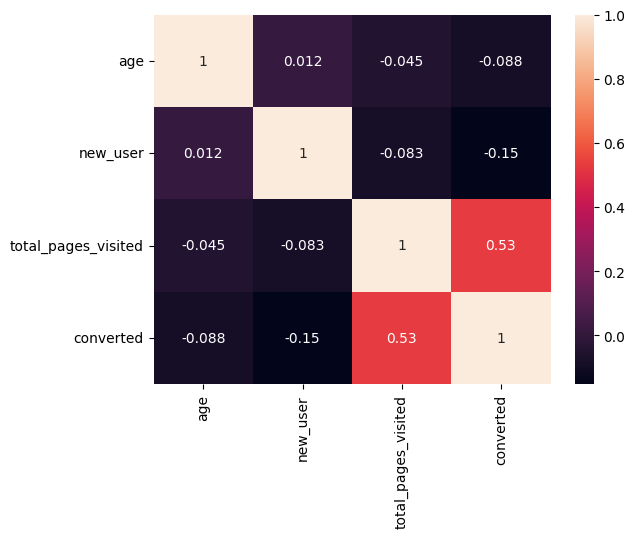

In [425]:
# correlation between variables
train_num = train.select_dtypes("number")
sns.heatmap(train_num.corr(), annot=True)
plt.show()

Questions:
- What is the average age of users? Is there a gap between those who subscribe and those who did not?


- Where are most of our subscribers from?
- What is our best source of conversions?
- What is the relationship between number of visited pages and conversions?
- Do sources vary in relation to country and age?

In [426]:
train.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


### What is the average age of users? Is there a gap between those who subscribe and those who did not?


In [427]:
print(f"Average age of subscribers: {train['age'].mean().round(2)}")

Average age of subscribers: 30.56


In [428]:
converted_age = train[train["converted"]==1]["age"].mean().round(2)
non_converted_age = train[train["converted"]==0]["age"].mean().round(2)
difference_age = (non_converted_age - converted_age).round(2)

print(f"Average age of people who were converted is of {converted_age}, while those who were not is of {non_converted_age}.\
       \nOn average, people who were converted are {difference_age} years younger than those who were not converted.")

Average age of people who were converted is of 26.57, while those who were not is of 30.7.       
On average, people who were converted are 4.13 years younger than those who were not converted.


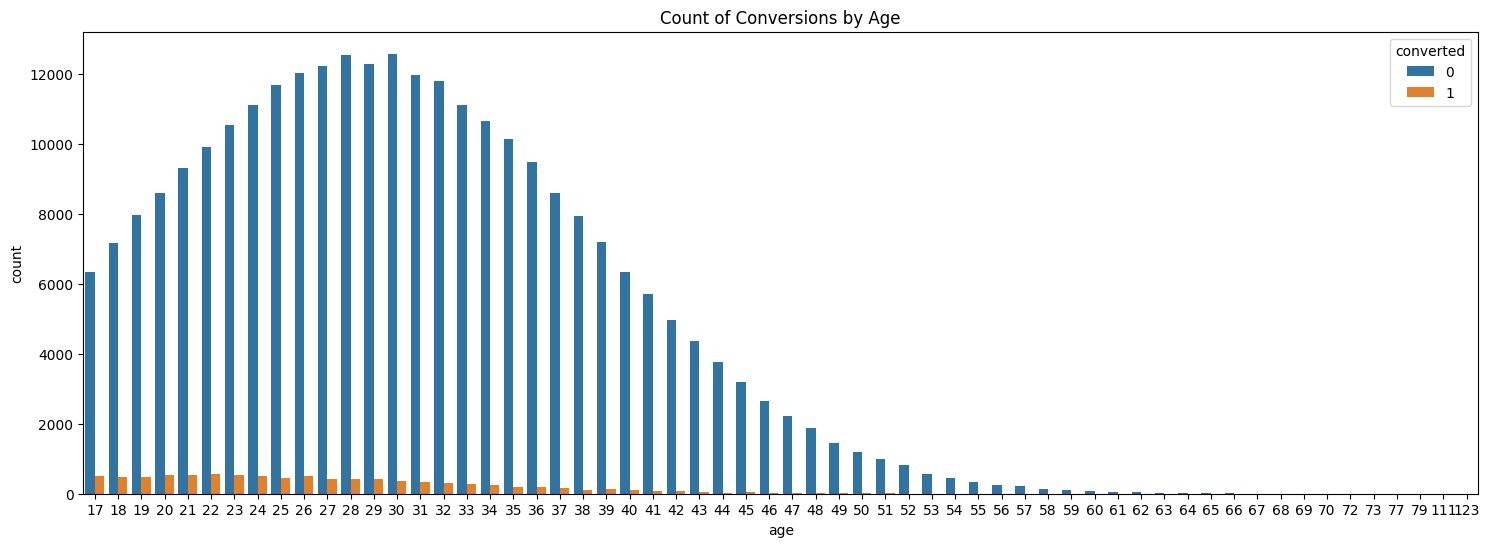

In [429]:
plt.figure(figsize=(18,6))
sns.countplot(data=train,
              x="age",
              hue="converted")
plt.title("Count of Conversions by Age")
plt.show()

In [430]:
# get proportion of conversions by age

# for every age, divide number of conversions between total observations
conversions_age_dict = {}
for age in np.unique(train["age"]):
    conversions_age_dict[age] = len(train[(train["age"]==age) & train["converted"]==1]) / len(train)

conversions_age_df = pd.DataFrame.from_dict(conversions_age_dict, orient="index")
conversions_age_df.rename(columns={0:"Conversion Rate"}, inplace=True)
conversions_age_df.head()

,Conversion Rate
17,0.001739
18,0.001729
19,0.001725
20,0.001845
21,0.001898


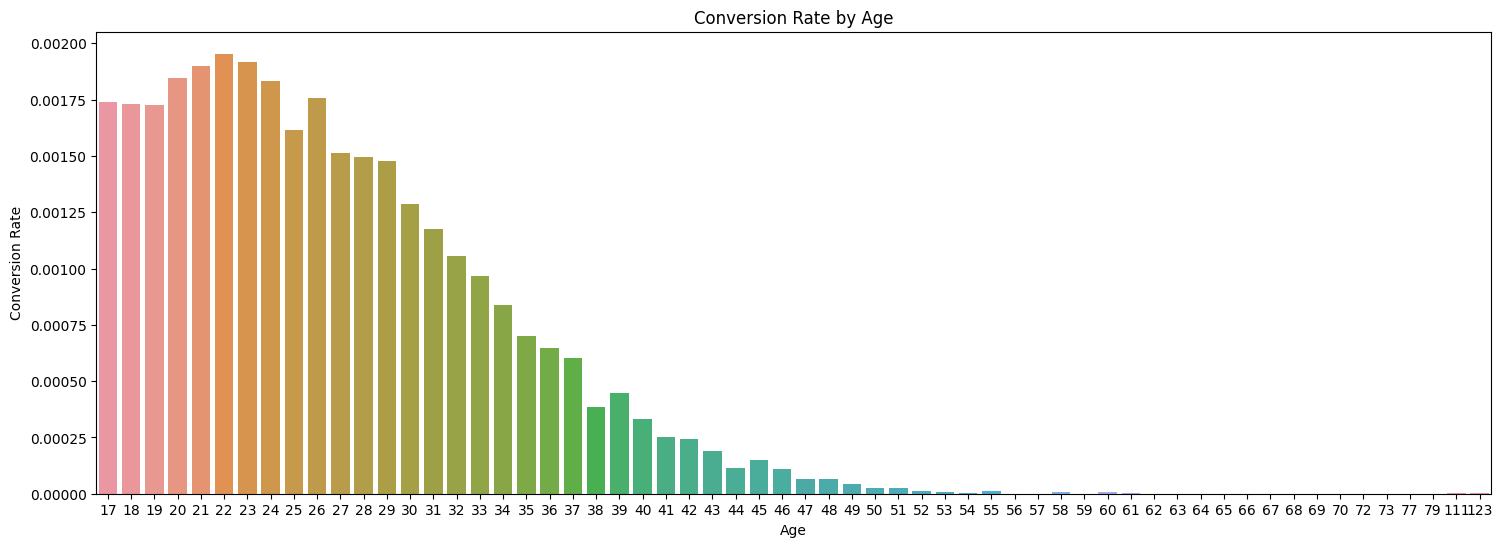

In [431]:
plt.figure(figsize=(18,6))
sns.barplot(data=conversions_age_df,
            x=conversions_age_df.index,
            y="Conversion Rate")
plt.xlabel("Age")
plt.title("Conversion Rate by Age")
plt.show()

##### Insight
- Most subscribers are young, the highest conversion rates are achieved between the ages of 17 and 26. 
- Conversion rate starts to plummet after age of 30. Because of this, it is necessary to focus on people between the ages of 17 and 29. 

### Where are subscribers from?

In [432]:
train["country"].value_counts(1).round(2)

country
US         0.56
China      0.24
UK         0.15
Germany    0.04
Name: proportion, dtype: float64

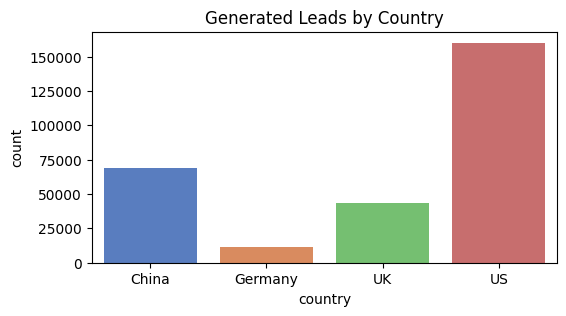

In [433]:
plt.figure(figsize=(6,3))
sns.countplot(data=train,
              x="country",
              palette="muted")
plt.title("Generated Leads by Country")
plt.show()

##### Insight
- More than half are American and only 4% are German. 
- Almost a quarter are Chinese and another 15% are British.

### What is the most used source of conversions?

In [434]:
# percentage of times each source was used
train["source"].value_counts(1).round(2)*100

source
Seo       49.0
Ads       28.0
Direct    23.0
Name: proportion, dtype: float64

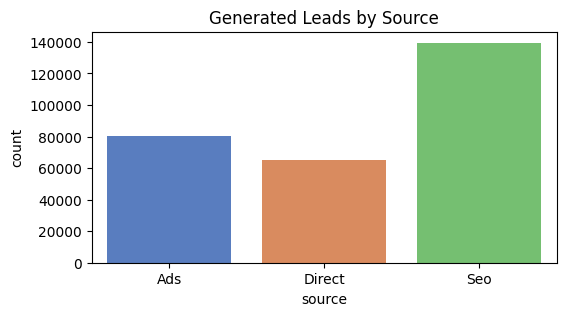

In [435]:
plt.figure(figsize=(6,3))
sns.countplot(data=train,
              x="source",
              palette="muted")
plt.title("Generated Leads by Source")
plt.show()

##### Insight
- SEO is by far the most used source, accounting for almost half of leads.
- Ads and Direct are used similarly, as Ads account for a little more than a quarter of leads, while Direct accounts for a little less than a quarter.

### Which one is the most effective source?

In [436]:
# create dataframe of only converted subscribers
converted = train[train["converted"]==1]
converted["source"].value_counts()

source
Seo       4585
Ads       2785
Direct    1810
Name: count, dtype: int64

In [437]:
# create masked dataframe for every source
# include dataframes of interest for analysis
# if all columns were included, a lot of memory would be taken
seo = train[train["source"]=="Seo"][["source", "converted", "country", "age"]]
ads = train[train["source"]=="Ads"][["source", "converted", "country", "age"]]
direct = train[train["source"]=="Direct"][["source", "converted", "country", "age"]]

In [438]:
# get conversion rate for every source
# multiply by 100 to get percentage

seo_conversion_rate = (seo["converted"].value_counts(1)*100).round(2)[1]
print(f"Conversion rate for SEO is: {seo_conversion_rate}")

ads_conversion_rate = (ads["converted"].value_counts(1)*100).round(2)[1]
print(f"Conversion rate for Ads is: {ads_conversion_rate}")

direct_conversion_rate = (direct["converted"].value_counts(1)*100).round(2)[1]
print(f"Conversion rate for Direct is: {direct_conversion_rate}")

Conversion rate for SEO is: 3.29
Conversion rate for Ads is: 3.48
Conversion rate for Direct is: 2.78


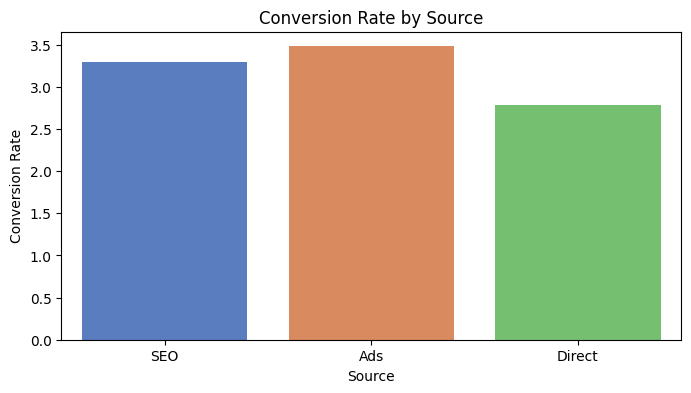

In [439]:
conversions_source_dict = {"SEO":seo_conversion_rate,
                    "Ads":ads_conversion_rate,
                    "Direct":direct_conversion_rate}

conversions_source_df = pd.DataFrame.from_dict(conversions_source_dict, orient="index").rename(columns={0:"Conversion Rate"})

plt.figure(figsize=(8,4))
sns.barplot(data=conversions_source_df,
            x=conversions_source_df.index,
            y="Conversion Rate",
            palette="muted")
plt.xlabel("Source")
plt.title("Conversion Rate by Source")
plt.show()

##### Insight
- Ads are the source with the highest conversion rate, but not by far as SEO is close behind.
- SEO is being used way more than Ads, even though that the latter is more effective. Marketing budgets come in to play, but it could be wise to start using more Ads at the expense of SEO and/or Direct.

### Does conversion by source vary in relation to country?

#### SEO

In [440]:
seo_converted_country_valcounts = seo[["country","converted"]].value_counts()
display(seo_converted_country_valcounts)
print()

# create dataframe from value counts
seo_converted_country_df = pd.DataFrame(seo_converted_country_valcounts).reset_index()
seo_converted_country_df

country  converted
US       0            75376
China    0            33836
UK       0            20296
Germany  0             5384
US       1             3020
UK       1             1154
Germany  1              368
China    1               43
Name: count, dtype: int64

,country,converted,count
0,US,0,75376
1,China,0,33836
2,UK,0,20296
3,Germany,0,5384
4,US,1,3020
5,UK,1,1154
6,Germany,1,368
7,China,1,43


In [441]:
# test
seo_converted_country_df[seo_converted_country_df["country"]=="US"]

,country,converted,count
0,US,0,75376
4,US,1,3020


In [442]:
# create list of countries to use in loop
countries = np.unique(train["country"])
countries

array(['China', 'Germany', 'UK', 'US'], dtype=object)

In [443]:
# test
# for every country create a dataframe that contains only rows with that country
for country in countries:
    df=seo_converted_country_df[seo_converted_country_df["country"]==country]
    display(df)

,country,converted,count
1,China,0,33836
7,China,1,43


,country,converted,count
3,Germany,0,5384
6,Germany,1,368


,country,converted,count
2,UK,0,20296
5,UK,1,1154


,country,converted,count
0,US,0,75376
4,US,1,3020


In [444]:
# create empty dictionary
# for each country create a dataframe that contains only rows with that country
# for each country divide number of converted people into total, to get conversion rate
# in empty dictionary create a key for every country and add conversion rate as value

seo_conversion_rates_country_dict = {}
for country in countries:
    df = seo_converted_country_df[seo_converted_country_df["country"]==country]
    seo_conversion_rates_country_dict[country] = (df.iloc[1].at["count"] / df["count"].sum()).round(4)*100

# convert dictionary to dataframe
seo_conversion_rates_country_df = pd.DataFrame.from_dict(seo_conversion_rates_country_dict, orient="index").rename(columns={0:"conversion_rate"})
seo_conversion_rates_country_df

,conversion_rate
China,0.13
Germany,6.40
UK,5.38
US,3.85


#### Direct
- Repeat exactly same process as SEO

In [445]:
direct_converted_country_valcounts = direct[["country","converted"]].value_counts()
display(direct_converted_country_valcounts)
print()

# create dataframe from value counts
direct_converted_country_df = pd.DataFrame(direct_converted_country_valcounts).reset_index()
direct_converted_country_df

country  converted
US       0            35568
China    0            15705
UK       0             9568
Germany  0             2425
US       1             1201
UK       1              453
Germany  1              137
China    1               19
Name: count, dtype: int64

,country,converted,count
0,US,0,35568
1,China,0,15705
2,UK,0,9568
3,Germany,0,2425
4,US,1,1201
5,UK,1,453
6,Germany,1,137
7,China,1,19


In [446]:
# test
direct_converted_country_df[direct_converted_country_df["country"]=="US"]

,country,converted,count
0,US,0,35568
4,US,1,1201


In [447]:
# create list of countries to use in loop
countries = np.unique(train["country"])
countries

array(['China', 'Germany', 'UK', 'US'], dtype=object)

In [448]:
# test
# for every country create a dataframe that contains only observations with that country
for country in countries:
    df=direct_converted_country_df[direct_converted_country_df["country"]==country]
    display(df)

,country,converted,count
1,China,0,15705
7,China,1,19


,country,converted,count
3,Germany,0,2425
6,Germany,1,137


,country,converted,count
2,UK,0,9568
5,UK,1,453


,country,converted,count
0,US,0,35568
4,US,1,1201


In [449]:
# create empty dictionary
# for each country create a dataframe that contains only rows with that country
# for each country divide number of converted people into total, to get conversion rate
# in empty dictionary create a key for every country and add conversion rate as value

direct_conversion_rates_country_dict = {}
for country in countries:
    df = direct_converted_country_df[direct_converted_country_df["country"]==country]
    direct_conversion_rates_country_dict[country] = (df.iloc[1].at["count"] / df["count"].sum()).round(4)*100

# convert dictionary to dataframe
direct_conversion_rates_country_df = pd.DataFrame.from_dict(direct_conversion_rates_country_dict, orient="index").rename(columns={0:"conversion_rate"})
direct_conversion_rates_country_df

,conversion_rate
China,0.12
Germany,5.35
UK,4.52
US,3.27


#### Ads
- - Repeat exactly same process as SEO and Direct

In [450]:
ads_converted_country_valcounts = ads[["country","converted"]].value_counts()
display(ads_converted_country_valcounts)
print()

# create dataframe from value counts
ads_converted_country_df = pd.DataFrame(ads_converted_country_valcounts).reset_index()
ads_converted_country_df

country  converted
US       0            43110
China    0            19492
UK       0            11486
Germany  0             3154
US       1             1849
UK       1              684
Germany  1              225
China    1               27
Name: count, dtype: int64

,country,converted,count
0,US,0,43110
1,China,0,19492
2,UK,0,11486
3,Germany,0,3154
4,US,1,1849
5,UK,1,684
6,Germany,1,225
7,China,1,27


In [451]:
# test
ads_converted_country_df[ads_converted_country_df["country"]=="US"]

,country,converted,count
0,US,0,43110
4,US,1,1849


In [452]:
# create list of countries to use in loop
countries = np.unique(train["country"])
countries

array(['China', 'Germany', 'UK', 'US'], dtype=object)

In [453]:
# test
# for every country create a dataframe that contains only observations with that country
for country in countries:
    df=ads_converted_country_df[ads_converted_country_df["country"]==country]
    display(df)

,country,converted,count
1,China,0,19492
7,China,1,27


,country,converted,count
3,Germany,0,3154
6,Germany,1,225


,country,converted,count
2,UK,0,11486
5,UK,1,684


,country,converted,count
0,US,0,43110
4,US,1,1849


In [454]:
# create empty dictionary
# for each country create a dataframe that contains only rows with that country
# for each country divide number of converted people into total, to get conversion rate
# in empty dictionary create a key for every country and add conversion rate as value

ads_conversion_rates_country_dict = {}
for country in countries:
    df = ads_converted_country_df[ads_converted_country_df["country"]==country]
    ads_conversion_rates_country_dict[country] = (df.iloc[1].at["count"] / df["count"].sum()).round(4)*100

# convert dictionary to dataframe
ads_conversion_rates_country_df = pd.DataFrame.from_dict(ads_conversion_rates_country_dict, orient="index").rename(columns={0:"conversion_rate"})
ads_conversion_rates_country_df

,conversion_rate
China,0.14
Germany,6.66
UK,5.62
US,4.11


### Comparison

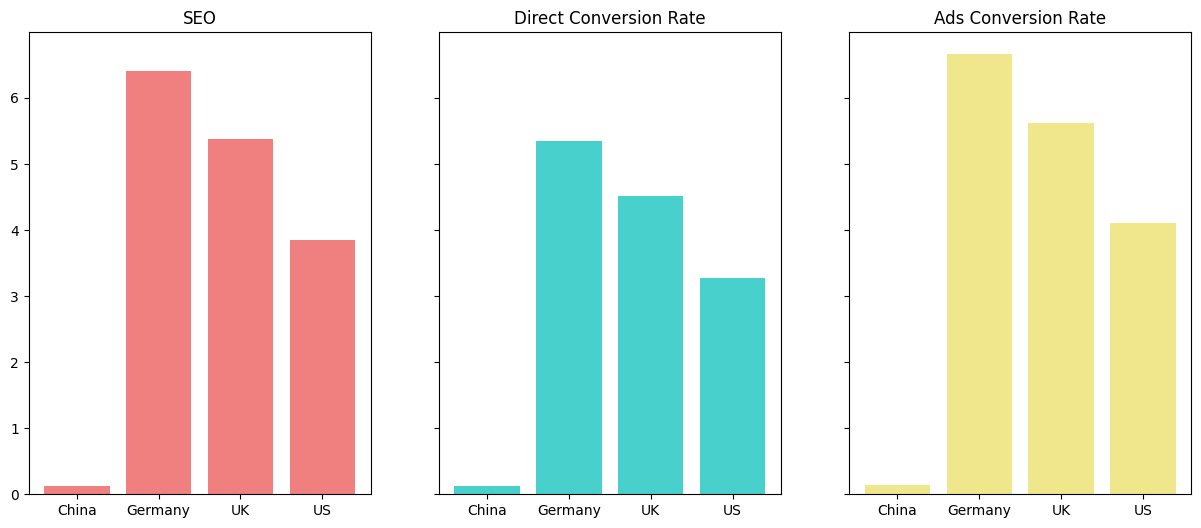

,SEO,Direct,Ads
China,0.13,0.12,0.14
Germany,6.40,5.35,6.66
UK,5.38,4.52,5.62
US,3.85,3.27,4.11


In [455]:
# barplots to compare conversion rates across countries

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
fig.set_figheight(6)
fig.set_figwidth(15)

# SEO
ax1.bar(x=seo_conversion_rates_country_df.index,
        height=seo_conversion_rates_country_df["conversion_rate"],
        color="lightcoral")
ax1.set_title("SEO")

# Direct
ax2.bar(x=direct_conversion_rates_country_df.index,
        height=direct_conversion_rates_country_df["conversion_rate"],
        color="mediumturquoise")
ax2.set_title("Direct Conversion Rate")

# Ads
ax3.bar(x=ads_conversion_rates_country_df.index,
        height=ads_conversion_rates_country_df["conversion_rate"],
        color="khaki")
ax3.set_title("Ads Conversion Rate")

# show
plt.show()

# same data presented as a dataframe
# rename columns for identification
seo_conversion_rates_country_df.rename(columns={"conversion_rate":"SEO"}, inplace=True)
direct_conversion_rates_country_df.rename(columns={"conversion_rate":"Direct"}, inplace=True)
ads_conversion_rates_country_df.rename(columns={"conversion_rate":"Ads"}, inplace=True)

frames = [seo_conversion_rates_country_df, direct_conversion_rates_country_df, ads_conversion_rates_country_df]
pd.concat(frames, axis=1)


##### Insight
- Sources are not different by country, as all sources perform the same across countries. Ads is best, followed by SEO and finally Direct.
- Conversion rates do vary though, being Germany the highest, followed by the UK, US and finally China.

#### What is the relationship between number of visited pages and conversions?

In [456]:
# get probability of conversion based on number of visited pages

# for every number of visited pages, divide number of conversions between total observations
conversions_pages_dict = {}
for page in np.unique(train["total_pages_visited"]):
    conversions_pages_dict[page] = len(train[(train["total_pages_visited"]==page) & train["converted"]==1]) / len(train)

conversions_pages_df = pd.DataFrame.from_dict(conversions_pages_dict, orient="index")
conversions_pages_df.rename(columns={0:"Probability"}, inplace=True)
conversions_pages_df.head()

,Probability
1,0.000000
2,0.000032
3,0.000039
4,0.000102
5,0.000179


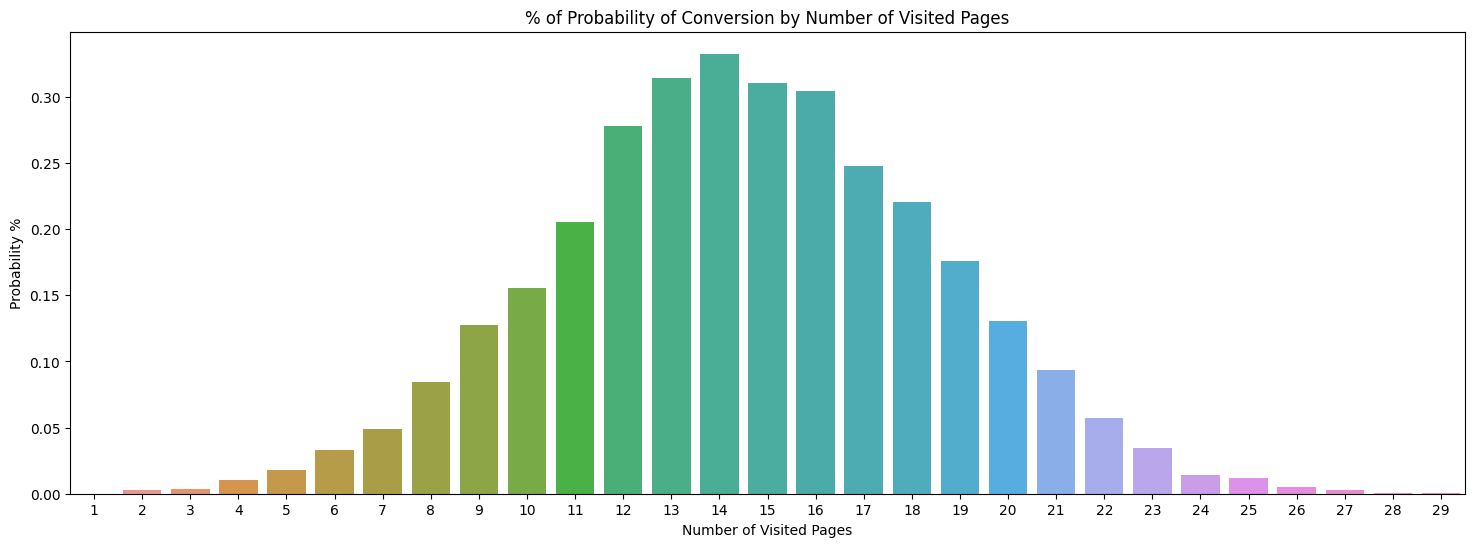

In [457]:
plt.figure(figsize=(18,6))
sns.barplot(data=conversions_pages_df*100,
            x=conversions_pages_df.index,
            y="Probability")
plt.xlabel("Number of Visited Pages")
plt.ylabel("Probability %")
plt.title("% of Probability of Conversion by Number of Visited Pages")
plt.show()

##### Insight
- Intuition suggests that the more pages one visits the higher probability of conversion is, but it is not that way.
- It is true up to a certain point. Between 12 and 17 pages we can observe the highest conversion rates, and after that the rate starts decreasing.

## Preprocessing

## Baseline Model

## Baseline Model Improvement

## Predictions on Test Data

## Hyperparameter Tuning